# Michelin NLP Capstone Project 
### Presented by: Yuvia Cardenas, Justin Evans, Cristina Lucin, and Woody Sims

# Project Overview:
Our Capstone Team Project utilizes Web-scraping & Natural Language Processing to develop a model that predicts Michelin food star award ratings based on content from the official Michelin review.

Following the *Data Science Pipeline*
First, our team will acquire and prepare the data for exploration. Then, we will explore the data to gain insight on which features to engineer that ultimately improve our model's accuracy. After we create several types of machine learning models that can effectly predict the Michelin food star award rating we will compare each model's performance on training and validate datasets. The model that performs the best will move forward with test dataset for final results. 

# Project Goals:
* Create a model that effectively predicts Michelin food star award ratings based on content from the official Michelin review
* Provide a well-documented jupyter notebook that contains our analysis
* Produce a Final GitHub repository
* Present a Canva slide deck suitable for a general audience which summarizes our findings and documents the results with well-labeled visualizations

# The Plan:
* Acquire initial data (CSV file) via `Kaggle` download
* Acquire review data using `Beautiful Soup` via 'get_michelin_pages' function in acquire file
* Clean and Prepare the data utilizing `RegEx` and string functions
* Create functional acquire.py, explore.py, and model.py files
* Explore data in search of significant relationships to target (Michelin Star Ratings) and produce visualizations encapsulating exploration 
* Conduct statistical testing as necessary
* Develop a Model to predict Award Category of Michelin restaurants:
    * Evaluate models on train and validate data using accuracy score
    * Select the best model based on the smallest difference in the accuracy score on the train and validate sets.
    * Evaluate the best model on test data
* Draw conclusions and document findings, takeaways, recommendations, and next steps


In [28]:
# Imports

import pandas as pd
import numpy as np
import re
import os

# Webscraping/NLP
import requests
from requests import get
from bs4 import BeautifulSoup
import time
import nltk
import requests
import unicodedata
from nltk.corpus import stopwords

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
import scipy.stats as stats
from scipy.stats import ttest_ind, levene, f_oneway

# Team Imports

import prepare as p
import acquire as a
import explore as e
import model as m
from importlib import reload
import warnings
warnings.simplefilter("ignore")


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier


# Acquire
- 6,780 Michelin website page URLs were acquired from a Michelin Kaggle Dataset of the current, quarterly Michelin Restaurants in the world (Kaggle Data Acquired 1/18/2023)
- These website pages were scraped utilizing BeautifulSoup utilizing a function called "get_michelin_pages"
- The text from the restaurant review was appended to the original Michelin Dataframe as a column titled "data"
- This dataframe included 6,780 rows before cleaning
- Each row represents a unique restaurant awarded and currently possessing a Michelin guide award designation
- Each column represents a feature of the restaurant, such as name, location, cuisine type, and price level

# Prepare
### Prepare Actions:
- Removed columns not necessary for project goals
- Dropped rows "restaurants" who no longer appear on the Michelin Guide Website (No longer a current Michelin Awardee)
- Recasted columns into appropriate data types
- Imputed null values where applicable
- Utilized Regex, string methods, and functions to clean restaurant review text
- Renamed columns and applied lowercase text throughout data to improve readability/usability
- Tokenized review text, removed stopwords, and lemmatized text for exploration and modeling

In [29]:
# Get the data, take a peek
df = a.get_michelin_pages()
df.head()

,name,address,location,price,cuisine,longitude,latitude,phone_number,url,website_url,award,facilities_and_services,data
0,King's Joy,"2 Wudaoying Hutong, Beijing, China Mainland","Beijing, China Mainland",¥¥¥,Vegetarian,116.410004,39.946681,8.610840e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","Just a stone’s throw from Yonghe Temple, this ..."
1,Xin Rong Ji (Xinyuan South Road),"1F, East Tower, Genesis Beijing, 8 Xinyuan Sou...","Beijing, China Mainland",¥¥¥¥,Taizhou,116.450148,39.946380,8.610650e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,Car park,China UnionPay,Count...",This branch of the chain restaurant opened in ...
2,Taian Table,"101-102, Building No. 1, Garden Office, No.161...","Shanghai, China Mainland",¥¥¥¥,Innovative,121.474049,31.221807,8.617302e+12,https://guide.michelin.com/en/shanghai-municip...,https://taian-table.cn/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",A fixture on the city’s dining scene since 201...
3,Ultraviolet by Paul Pairet,'somewhere in Shanghai' - meet at Mr & Mrs Bun...,"Shanghai, China Mainland",¥¥¥¥,Innovative,121.485090,31.240358,NaN,https://guide.michelin.com/en/shanghai-municip...,https://uvbypp.cc/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",This multi-sensory experience at a secret loca...
4,Quince,"470 Pacific Ave., San Francisco, 94133, USA","San Francisco, USA",$$$$,"Contemporary, Californian",-122.403261,37.797505,1.415776e+10,https://guide.michelin.com/en/california/san-f...,http://www.quincerestaurant.com,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","An air of refinement infuses this dining room,..."


In [30]:
# Take a look at some restaurant reviews from our dataframe:
print(f'Kings Joy (Beijing, China) review text: {df.data[0]}')

Kings Joy (Beijing, China) review text: Just a stone’s throw from Yonghe Temple, this serene restaurant is remodelled from a courtyard house and features a glass-roofed dining room. The chef honed his skills at his grandparents’ restaurant of the same name. Only set menus are available; try the classic menu to sample their specialities all at once. Regulars may opt for the solar-term menu that changes every 15 days. Live harp performance befits the restaurant’s classy elegance.


In [31]:
# Take a look at some restaurant reviews from our dataframe:
print(f'La Palme dOr (Cannes, France) review text: {df.data[500]}')

La Palme dOr (Cannes, France) review text: Some places you fall in love with at first sight and La Palme d'Or is one of them. In the fabulous Art Deco setting of the Hotel Martinez, diners look down on the famous promenade of La Croisette and the Bay of Cannes, while savouring the luxury and refinement so beautifully brought together here. Of course, all this would be worth nothing without high-calibre cuisine. No worries on that score: chef Christian Sinicropi, a local man, has matters entirely in hand. At each stage of the "Mouvements" set menu, he homes in on one ingredient, supporting it with elements from its own ecosystem. The result is coherent and sophisticated, right down to the remarkably precise desserts by Julien Ochando. Definitely worthy of a Golden Palm award.


_________________________________

# Exploration

In [32]:
# Splitting our data (56% Train, 24% Validate, 20% Test)
train, validate, test = p.prepare_michelin(df)
train.head(2)

,name,address,location,price,cuisine,longitude,latitude,url,award,facilities_and_services,data,price_level,city,country,clean,lemmatized,sentiment,word_count
6345,gasthaus ödenturm,"am ödenturm 11, cham, 93413, germany","cham, germany",€,"country cooking, mediterranean cuisine",12.703851,49.210919,https://guide.michelin.com/en/bayern/cham/rest...,bib gourmand,"car park,credit card / debit card accepted,gre...","as if straight out of a picture book, this bea...",1,cham,germany,straight picture book beautiful inn stands edg...,straight picture book beautiful inn stand edge...,0.9648,36
6427,weinhaus anker,"obertorstraße 13, marktheidenfeld, 97828, germany","marktheidenfeld, germany",€,"french, country cooking",9.600301,49.845621,https://guide.michelin.com/en/bayern/marktheid...,bib gourmand,"american express credit card,car park,credit c...",a restaurant that is steeped in tradition and ...,1,marktheidenfeld,germany,steeped tradition run great commitment lovely ...,steeped tradition run great commitment lovely ...,0.9618,32


## Question 1: What is the distribution of our target variable (award type)?

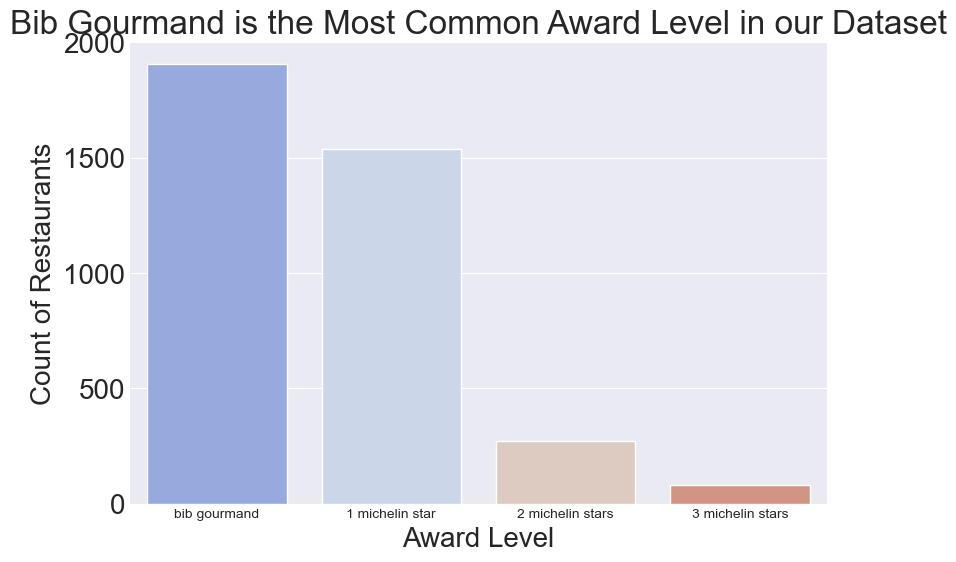

In [33]:
# Generate visuazliation of distribution of target variable
e.get_award_freq(train)

In [34]:
# Establishing Baseline for modeling, with the Mode being 'bib gourmand'
len(train[train.award == 'bib gourmand']) / len(train.award)

0.5030319008700237

## Question 2: What Countries have the most Michelin Restaurants?

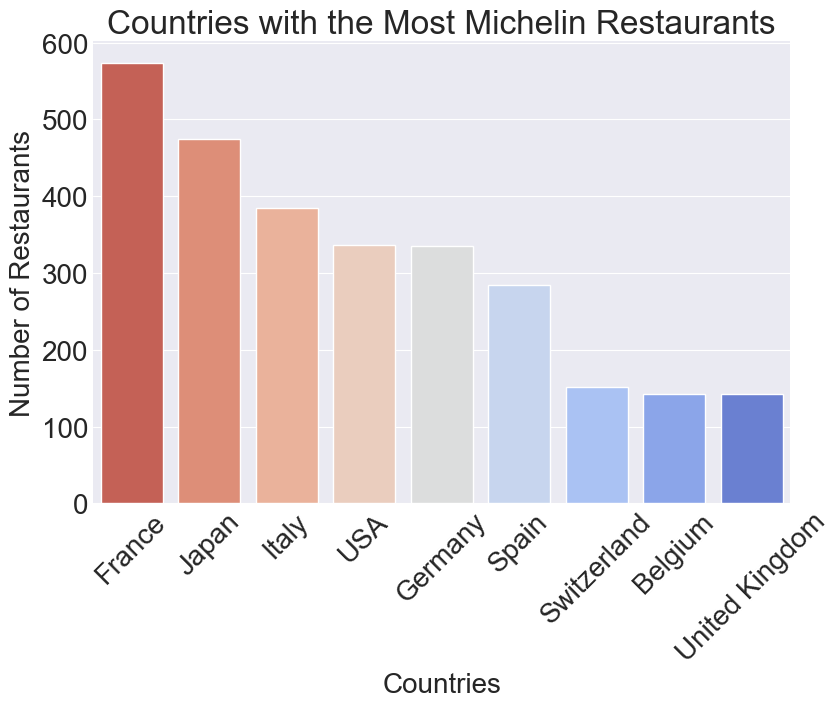

In [35]:
# Generate visualizaion of count of Michelin awardees by country
e.top_10_country_viz(train)

## Question 3: What is the average wordcount of restaurant reviews, by award type?

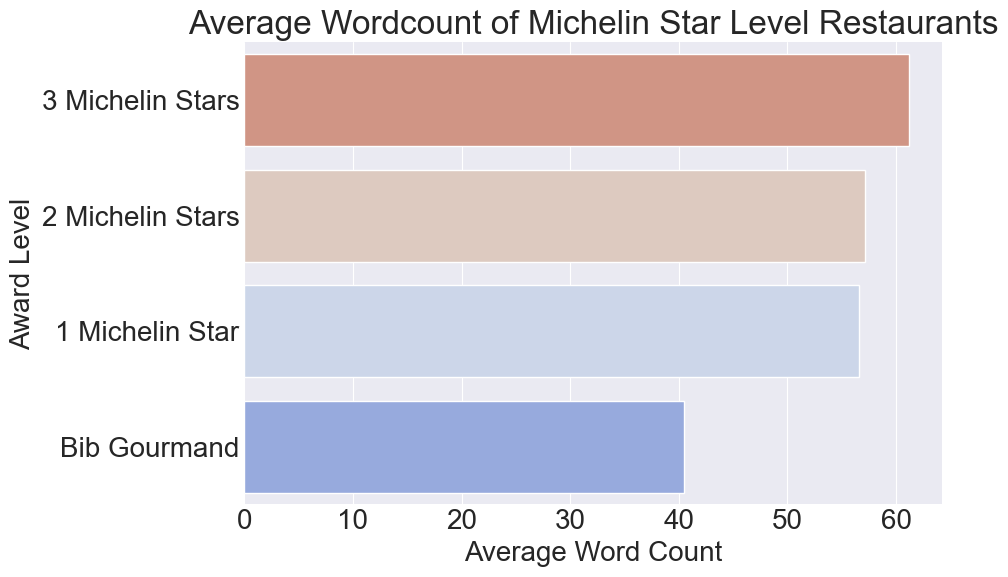

In [36]:
# Generate Visualization of average wordcount by Michelin award category
e.get_wordcount_bar(train)

### We conducted an ANOVA (Analysis of Variance) test to determine if there is a significant difference in review wordcount:

In [37]:
# Generate visualization of wordcount by award category
e.get_anova_wordcount(train)

We reject the null hypothesis. There is sufficient
evidence to conclude that the word count is significantly
different between award categories.


## Question 4: Do three star Michelin restaurants have the highest sentiment score?

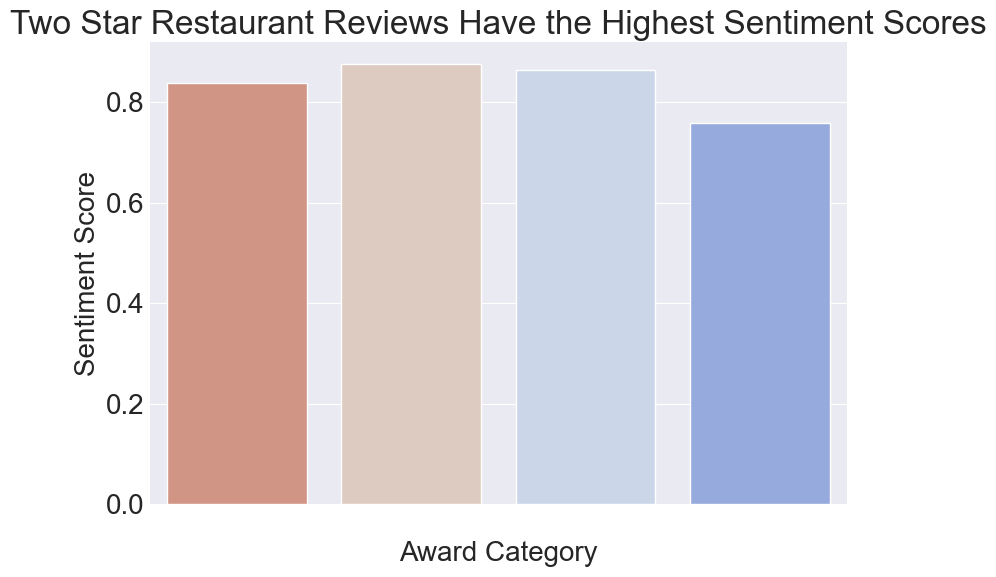

In [38]:
# Generate visualization for sentiment score
e.sentiment_scores_bar(train)

- Sentiment scores for all categories are generally favorable
- Restaurants awarded three (3) Michelin stars had the highest sentiment score

## Question 5: What are the most frequent words used in Michelin Restaurant reviews?

In [39]:
# Most frequent single words
e.get_ngram_frequency(train.lemmatized, n=1).head(5)

modern     831
room       778
wine       720
kitchen    713
one        662
dtype: int64

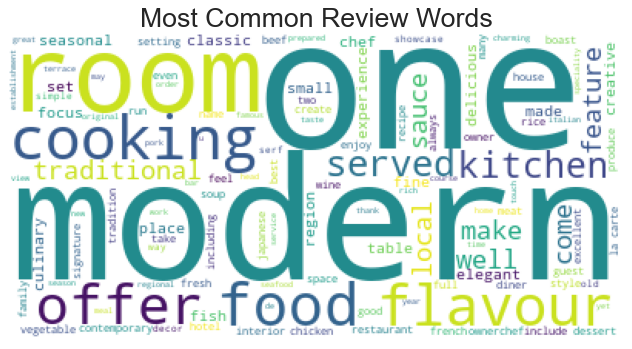

In [40]:
# Show Word Cloud for Top Single Words
e.QMCBT_viz_wc()

In [41]:
# Most frequent bigrams
e.get_ngram_frequency(train.lemmatized, n=2).head(5)

la carte        213
tasting menu    142
open kitchen    120
set menu        110
wine cellar      83
dtype: int64

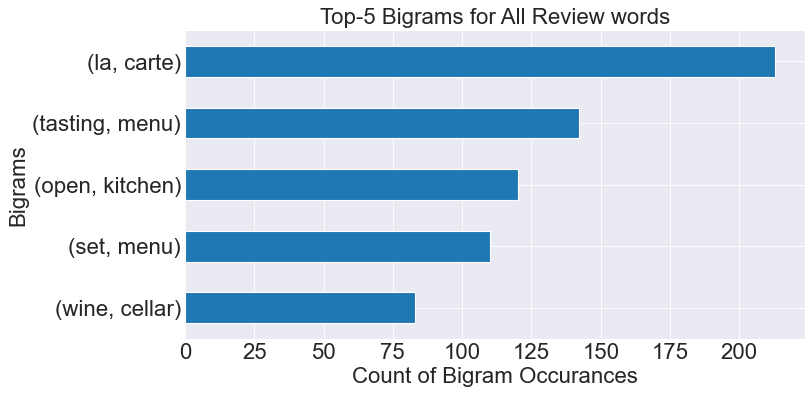

In [42]:
# Show visualization for Top-5 Bigrams
e.QMCBT_viz_2()

In [43]:
# Most frequent trigrams
e.get_ngram_frequency(train.lemmatized, n=3).head(5)

two tasting menu         39
take pride place         35
three tasting menu       31
two set menu             24
excellent value money    19
dtype: int64

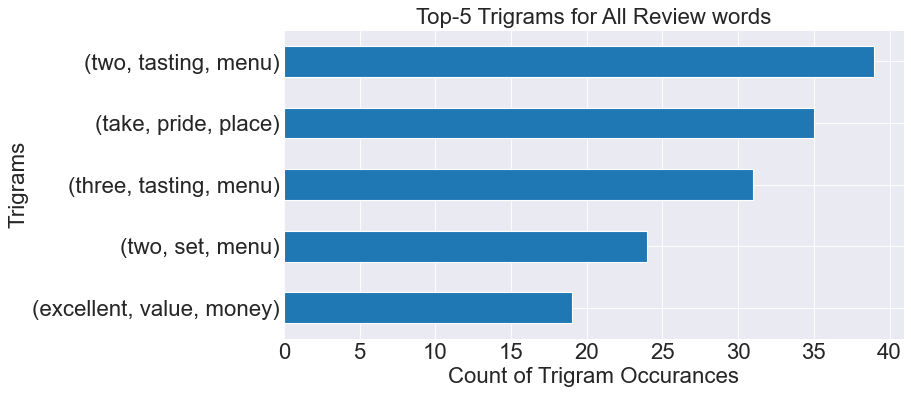

In [44]:
# Show visualization for Top-5 Trigrams
e.QMCBT_viz_3()

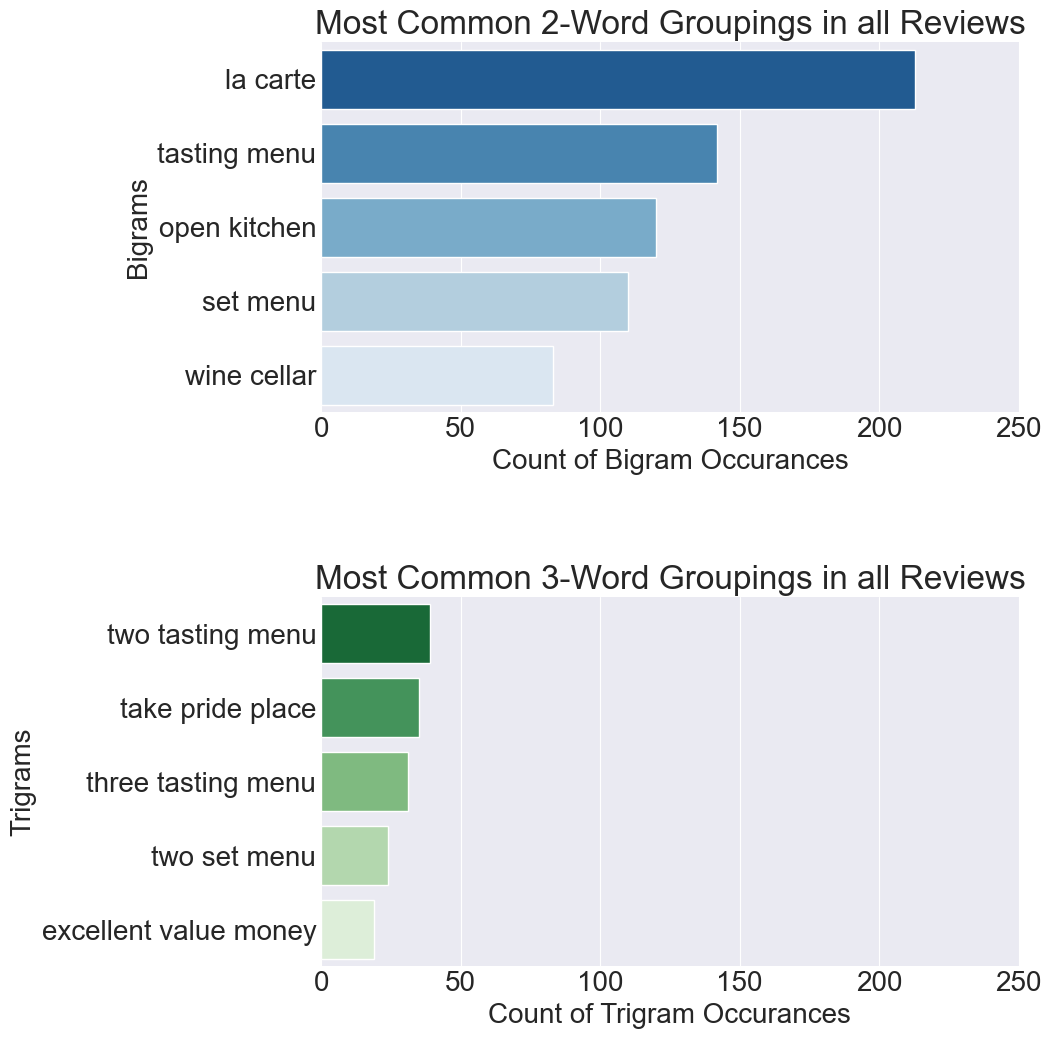

In [51]:
# Show visualization for Top-5 Bigrams and Trigrams
reload(e)
e.QMCBT_BiTrigrams_bar()

<div class="alert alert-warning">

## Question 6: Is there a relationship between Reviews and Facilities?

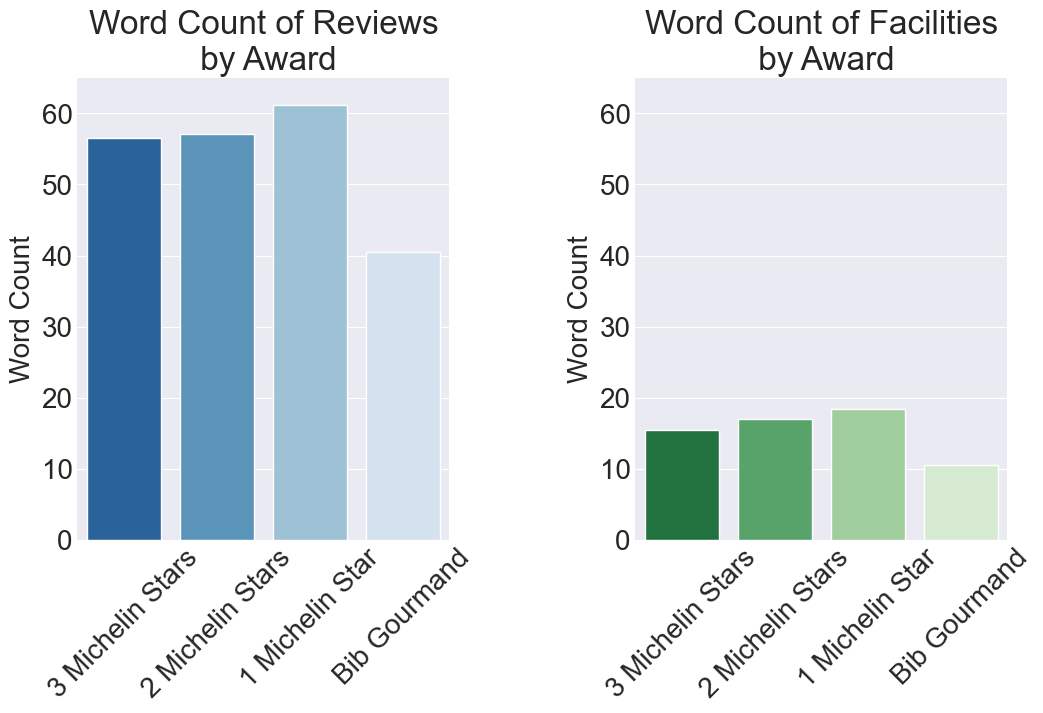

In [20]:
# Show visualization for Reviews vs Facilities
e.QMCBT_viz_4()

**Verify Assumptions**
* How big is sample size?
* If sample size is significantly > 30, we don't have to worry about normality (CLT!!)

In [21]:
e.stat_levene()

equal_var = True (we will assume equal variance)
_______________________________________________________________
t-stat: 0.549073797844228
p-value: 0.48667314311884785


### Test Hypothosis

In [22]:
e.stat_pearson()

Reject the null hypothesis
_____________________
correlation 0.9829
p-value 0.0171


<div class="alert alert-info">

### Takeaways:

### Q6. Is there a relationship between Reviews and Facilities?

### YES reviews **has** a ```significant relationship``` with facilities as verified by Pearson's-R test

## WordClouds

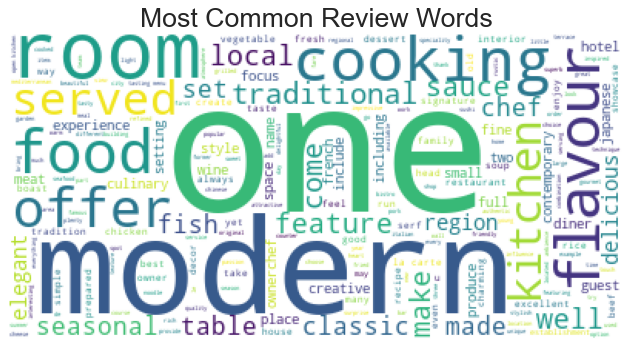

In [23]:
# WC for all single words 
e.QMCBT_viz_wc()

## Exploration Summary

- "Bib Gourmand" Award Level is the most common award category (baseline is 50.3%)
- France has the most Michelin awarded restaurants, followed by Japan, Italy, U.S.A and Germany)
- Restaurants awarded three (3) Michelin stars had reviews with the most words, and Bib Gourmand Restaurants had the fewest word count
- Restaurants awarded two (2) Michelin stars had the highest sentiment score, and Bib Gourmand restaurants had the lowest sentiment score
- "Modern", "Room" and "Wine" are the most common words
- "La Carte", "Tasting Menu" and "Open Kitchen" are the most common two-word combinations (bi-grams)
- "Two tasting menu" and "Take Pride Place" ar ethe most common three-word combinations (tri-grams)
- Higher-rated restaurants had more facilities than lower rated restaurants

________________________________________________________________________________________________________

# Modeling

- We utilized accuracy as the evaluation metric
- We developed four different models using different model types: (Decision Tree, Random Forest, Logistic Regression, eXtreme Gradient Boosting (XGBoost))
- The best application (via Grid Search and Hyperparameter tuning) was selected for evaluation of test data
- We utilized the mode of 'Bib Gourmand' as the baseline (50.3%)
- We explored several methods of NLP modeling. We elected to utilize as much useful text as possible, removing a small number of stopwords and ngrams from the lemmatized dataset. 

In [24]:
# Get Baseline
baseline = m.get_baseline(train)
baseline


,Accuracy Score
Baseline,0.503032


### Initial Model Training

In [25]:
models = [DecisionTreeClassifier(max_depth=2),
            RandomForestClassifier(
                max_depth=5,
                n_estimators=50,
                min_samples_leaf=3,
                random_state=27,
                n_jobs=5,
                ),
            LogisticRegression(C=.05,
                                penalty='l1',
                                random_state=27,
                                solver='liblinear',
                                tol=.0001,
                                n_jobs=5,
                                ),
            GradientBoostingClassifier(n_estimators=50,
                                        max_depth=4,
                                        min_samples_leaf=4,
                                        random_state=27,
                                        )]
scaler = MinMaxScaler()
tfidf = TfidfVectorizer(ngram_range=(1,2))

In [26]:
# Run modeling function
m.run_train_and_validate(train, validate,models,tfidf,scaler)

,Train,Validate
DecisionTreeClassifier,0.882679,0.884379
RandomForestClassifier,0.564461,0.522755
LogisticRegression,0.881888,0.885609
GradientBoostingClassifier,0.923280,0.876384


### Testing selected model on unseen data (Test)

In [27]:
#Place final model test here
yhat_test = m.run_test(test,models[2],tfidf,scaler)
pd.concat([baseline,yhat_test])

,Accuracy Score
Baseline,0.503032
LogisticRegression,0.878967


## Modeling Summary

## Takeaways/Conclusions

- Restaurants with higher Michelin award levels have, on average, longer reviews
- France, Japan, and Italy have the most Michelin restaurants
- Two (2) Star Michelin Restaurant reviews have the highest sentiment levels, followed by one (1) star restaurants, three (3) star restaurants, and Bib Gourmand restaurants. However, the difference in sentiment levels between the star categories was not significant.
- Utilizing the cleaned and lemmatized text of reviews, we produced a model that predicts, with 87.9% accuracy, the award category of a restaurant.
- Our results suggest that the way Michelin reviewers talk about restaurants is impactful and meaningful, and further exploration could yield valuable results


## Recommendations


- To imrpove your chances for Michelin designation, "shoot for the stars"
- The higher level a restaurant is rated, the more service focused words, groups of two and three words occur in the review
- An improvement in dining experience, seems to be the biggest driver towards a three-star restaurant review

## Next Steps

- Pruning TF/IDF to hone model performance
- Investigate deep learning to further improve model accuracy
- Exploration of restaurant cuisine type to feature engineer
- Investigation and deeper exploration of unique words and phrases
- Clustering features for modeling